In [1]:
from __future__ import print_function
import datetime
from functools import reduce
import os

import pandas as pd
import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt

from fastset import FastSet

In [2]:
# Data collected from a spark query at CERN, in pandas pickle format
# CRAB jobs only have data after Oct. 2017
ws = pd.read_pickle("data/working_set_day.pkl.gz")
# spark returns lists, we want to use sets
ws['working_set_blocks'] = ws.apply(lambda x: FastSet(x.working_set_blocks), 'columns')
ws['working_set'] = ws.apply(lambda x: FastSet(x.working_set), 'columns')

<IPython.core.display.Javascript object>


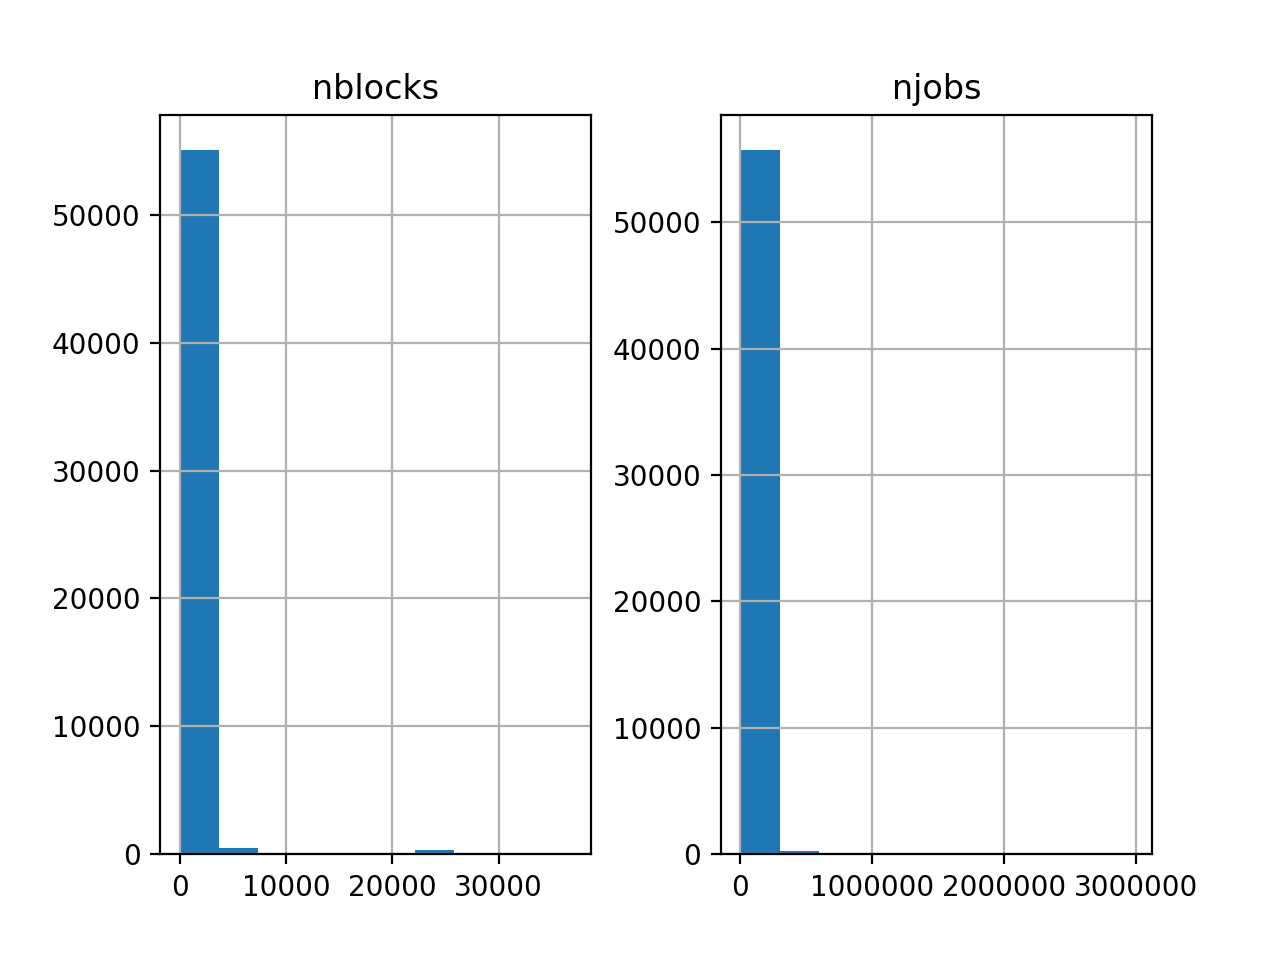

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11babf0f0>,
      dtype=object)

In [3]:
pd.DataFrame({'nblocks':ws.apply(lambda x: len(x.working_set_blocks), 'columns'), 'njobs':ws.njobs}).hist()

In [9]:
#   DBS BLOCKS table schema:
#     BLOCK_ID NOT NULL NUMBER(38)
#     BLOCK_NAME NOT NULL VARCHAR2(500)
#     DATASET_ID NOT NULL NUMBER(38)
#     OPEN_FOR_WRITING NOT NULL NUMBER(38)
#     ORIGIN_SITE_NAME NOT NULL VARCHAR2(100)
#     BLOCK_SIZE NUMBER(38)
#     FILE_COUNT NUMBER(38)
#     CREATION_DATE NUMBER(38)
#     CREATE_BY VARCHAR2(500)
#     LAST_MODIFICATION_DATE NUMBER(38)
#     LAST_MODIFIED_BY VARCHAR2(500)
if not os.path.exists('data/block_size.npy'):
    blocksize = pd.read_csv("data/dbs_blocks.csv.gz", dtype='i8', usecols=(0,5), names=['block_id', 'block_size'])
    np.save('data/block_size.npy', blocksize.values)
    blocksize = blocksize.values
else:
    blocksize = np.load('data/block_size.npy')

# We'll be accessing randomly, make a dictionary
#blocksize = {v[0]:v[1] for v in blocksize}

In [12]:
blocksize

array([[      555044, 103414137568],
       [      555045,  60464996588],
       [      555674,  42051383424],
       ...,
       [    19843759,   1968676046],
       [    19817185,    216801160],
       [    19817184,    115498385]])

In [5]:
# join the data tier definitions
datatiers = pd.read_csv('data/dbs_datatiers.csv').set_index('id')
ws['data_tier'] = datatiers.loc[ws.d_data_tier_id].data_tier.values

In [6]:
date_index = np.arange(np.min(ws.day.values//86400), np.max(ws.day.values//86400)+1)
date_index_ts = np.array(list(datetime.date.fromtimestamp(day*86400) for day in date_index))

ws_filtered = ws[(ws.crab_job==True) & (ws.data_tier.str.contains('MINIAOD'))]

blocks_day = []
for i, day in enumerate(date_index):
    today = (ws_filtered.day==day*86400)
    blocks_day.append(reduce(FastSet.union, ws_filtered[today].working_set_blocks, FastSet()))

print("Done assembling blocklists")

Done assembling blocklists


In [8]:
nrecords = np.zeros_like(date_index)
lifetimes = {
    '1w': 7,
    '1m': 30,
    '3m': 90,
    #'6m': 120,
}
ws_size = {k: np.zeros_like(date_index) for k in lifetimes}
nrecalls = {k: np.zeros_like(date_index) for k in lifetimes}
recall_size = {k: np.zeros_like(date_index) for k in lifetimes}
previous = {k: FastSet() for k in lifetimes}

for i, day in enumerate(date_index):
    nrecords[i] = ws_filtered[(ws_filtered.day==day*86400)].size
    for key in lifetimes:
        current = reduce(FastSet.union, blocks_day[max(0,i-lifetimes[key]):i+1], FastSet())
        recall = current - previous[key]
        nrecalls[key][i] = len(recall)
        ws_size[key][i] = sum(blocksize[bid] for bid in current)
        recall_size[key][i] = sum(blocksize[bid] for bid in recall)
        previous[key] = current
    if i%30==0:
        print("Day ", i)

print("Done")

Day  0
Day  30
Day  60
Day  90
Day  120
Day  150
Day  180
Day  210
Day  240
Day  270
Day  300
Day  330
Day  360
Day  390
Day  420
Day  450
Day  480
Day  510
Day  540
Day  570
Day  600
Day  630
Day  660
Day  690
Day  720
Day  750
Done


<IPython.core.display.Javascript object>


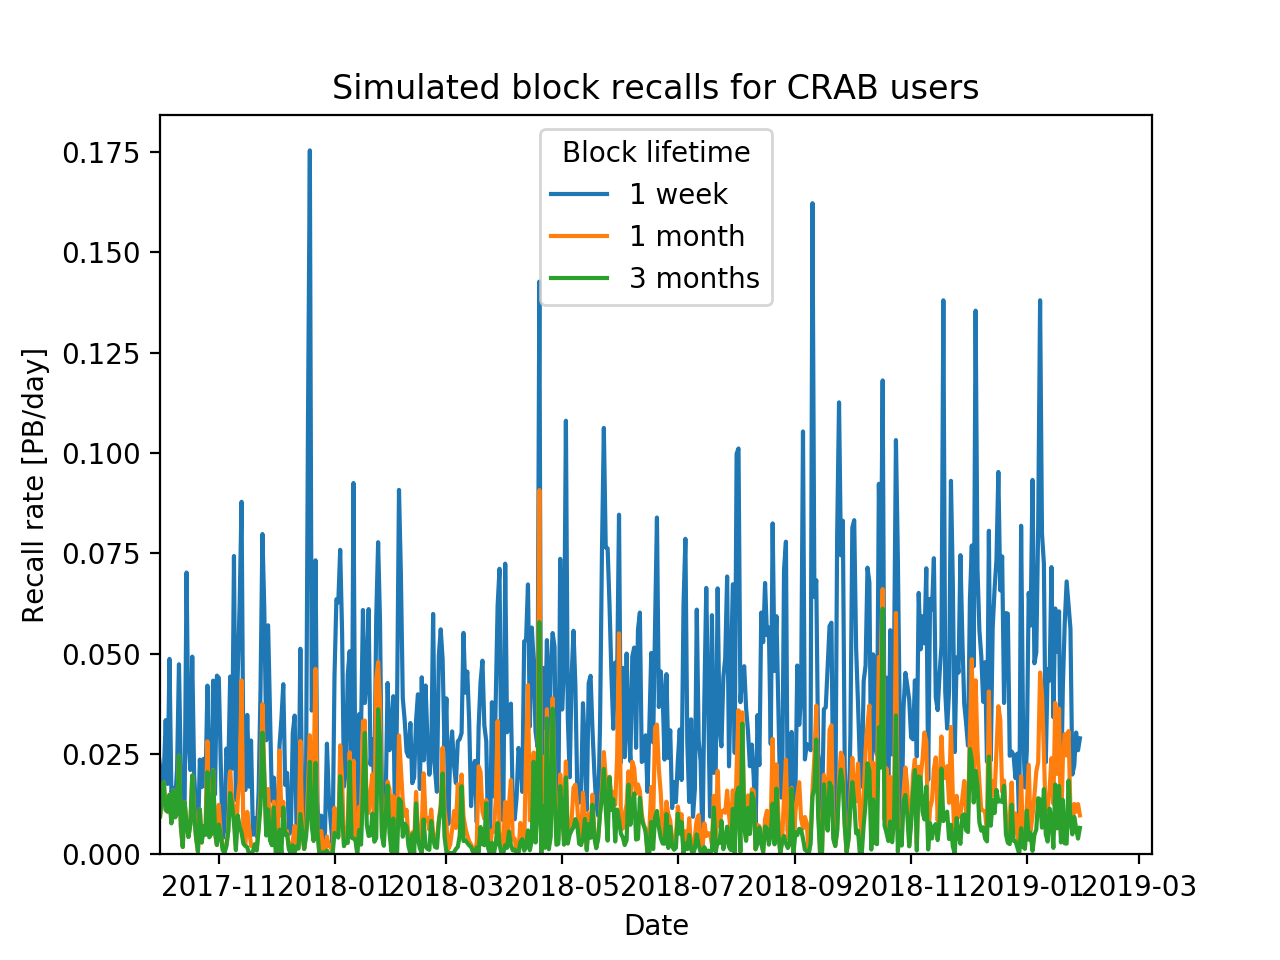

(736603.0, 737126.0)

In [20]:
fig, ax = plt.subplots(1,1)
ax.plot(date_index_ts, recall_size['1w']/1e15, label='1 week')
ax.plot(date_index_ts, recall_size['1m']/1e15, label='1 month')
ax.plot(date_index_ts, recall_size['3m']/1e15, label='3 months')
ax.legend(title='Block lifetime')
ax.set_title('Simulated block recalls for CRAB users')
ax.set_ylabel('Recall rate [PB/day]')
ax.set_xlabel('Date')
ax.set_ylim(0, None)
ax.set_xlim(datetime.date(2017,10,1), None)

<IPython.core.display.Javascript object>


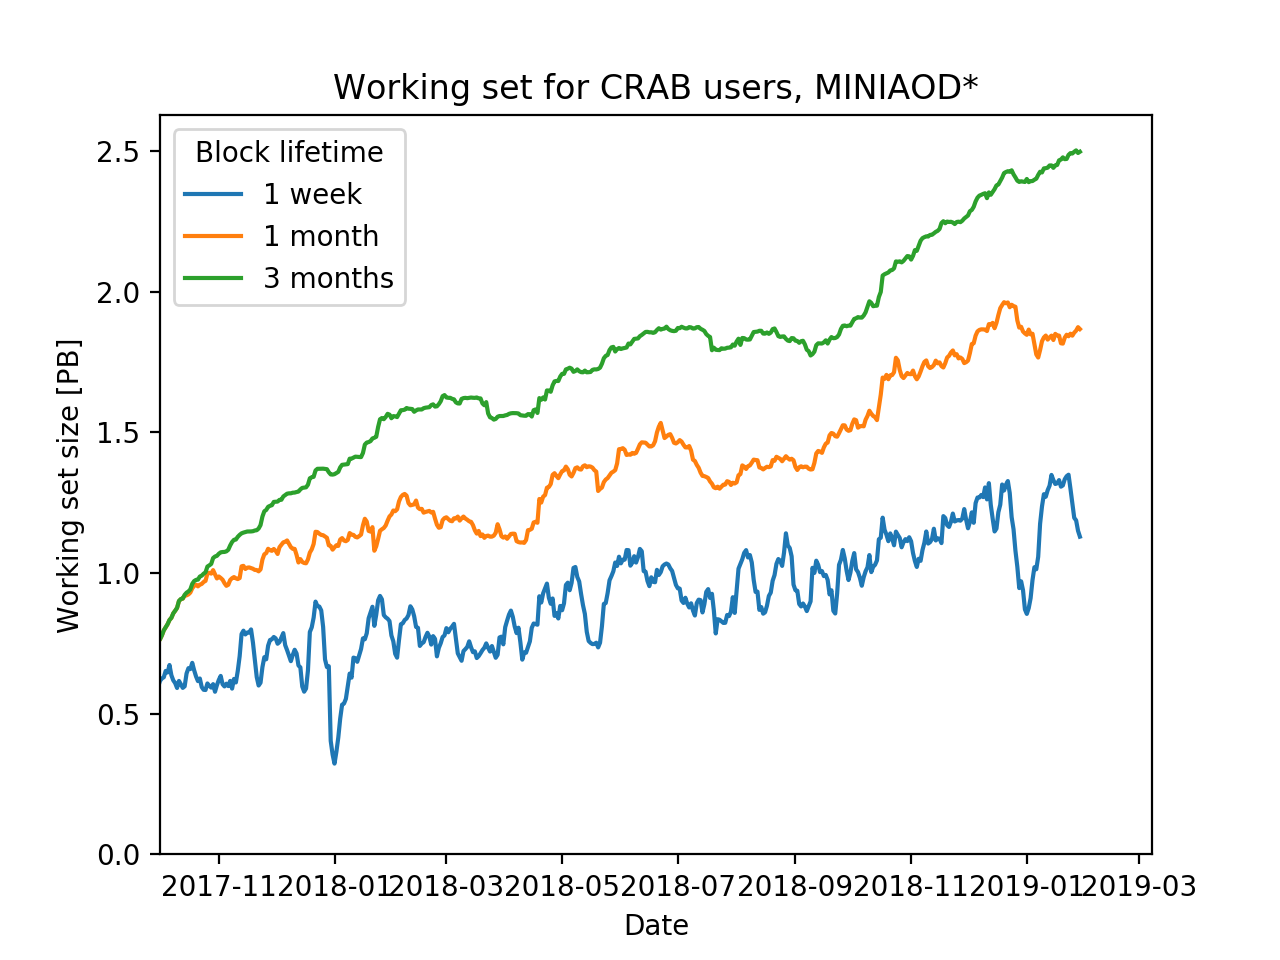

(736603.0, 737126.0)

In [54]:
fig, ax = plt.subplots(1,1)
ax.plot(date_index_ts, ws_size['1w']/1e15, label='1 week')
ax.plot(date_index_ts, ws_size['1m']/1e15, label='1 month')
ax.plot(date_index_ts, ws_size['3m']/1e15, label='3 months')
ax.legend(title='Block lifetime')
ax.set_title('Working set for CRAB users, MINIAOD*')
ax.set_ylabel('Working set size [PB]')
ax.set_xlabel('Date')
ax.set_ylim(0, None)
ax.set_xlim(datetime.date(2017,10,1), None)

In [30]:
recall_size['3m'].mean()/1e12

5.696515582485798